In [1]:
import datetime
import numpy as np
import pandas as pd
import jax.numpy as jnp
import numpyro
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
from sklearn.preprocessing import MinMaxScaler

In [2]:
# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.0f}'.format

In [3]:
df = pd.read_csv('source/Sample Media Spend Data.csv')
df.head()

,Division,Calendar_Week,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales
0,A,1/6/2018,392,422,408,349895,73580,12072,682,59417
1,A,1/13/2018,787,904,110,506270,11804,9499,853,56806
2,A,1/20/2018,81,970,742,430042,52232,17048,759,48715
3,A,1/27/2018,25,575,65,417746,78640,10207,942,72047
4,A,2/3/2018,565,284,295,408506,40561,5834,658,56235


In [4]:
df.dtypes

Division                  object
Calendar_Week             object
Paid_Views                 int64
Organic_Views              int64
Google_Impressions         int64
Email_Impressions        float64
Facebook_Impressions       int64
Affiliate_Impressions      int64
Overall_Views              int64
Sales                      int64
dtype: object

In [5]:
df['Calendar_Week'] = pd.to_datetime(df['Calendar_Week'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')

In [6]:
print(f"{len(df)} rows")
print(f"Unique divisions: {np.unique(df['Division'])}")
print(f"Minimum date week: {np.min(df['Calendar_Week'])}")
print(f"Maximum date week: {np.max(df['Calendar_Week'])}")

3051 rows
Unique divisions: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
Minimum date week: 2018-01-06
Maximum date week: 2020-02-29


In [7]:
df.describe()

,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales
count,3051,3051,3051,3051,3051,3051,3051,3051
mean,15094,13356,886174,760509,269127,22911,27981,185901
std,30786,24079,1355076,626014,466512,21618,52055,232208
min,1,1,7,40894,29,910,2,15436
25%,537,712,169828,378497,57074,9127,747,73394
50%,2699,4110,490531,590971,127523,16658,7879,113573
75%,17358,16230,1022622,962247,283505,27486,34112,202976
max,518190,270453,17150439,7317730,7558435,175791,635057,3575430


In [8]:
## Data Interpretation Simulation
# Costs columns: paid views, google impressions, facebook impressions and affiliate impressions (in $)
# Count columns: organic views and email impressions
# Response variable: Sales (in $)

In [50]:
data_size = len(df)
split_point = data_size - 20

# Media data
media_cols = ['Paid_Views', 'Google_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions']
len_media_cols = len(media_cols)
media_data = df[['Paid_Views', 'Google_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions']].to_numpy()
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# Extra features
extra_features_cols = ['Organic_Views', 'Email_Impressions']
len_extra_features_cols = len(extra_features_cols)
extra_features = df[extra_features_cols].to_numpy()
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]

# Target 
target = df['Sales'].to_numpy()
target_train = target[:split_point, ...]
target_test = target[split_point:, ...]

# Costs (media prior: mandatory)
# costs shouldn't be 0 or negative for the fit() method
# More generally though, media channels in an MMM should usually have non-zero costs, 
# especially if you want to compute ROIs later in the process and perform channel optimization.
costs = df[media_cols].sum().to_numpy()

In [51]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
# no 0 or negative values for the media prior argument
# cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean) # got negative values???
# cost_scaler = MinMaxScaler(feature_range=(0.01, 1))
costs_mean = costs.mean()
costs = [c / costs_mean for c in costs]

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
# costs = cost_scaler.fit_transform(costs)
# costs = cost_scaler.fit_transform(costs.reshape(-1, 1)).reshape(1, -1)[0]

In [53]:
# Adstock: Applies an infinite lag that decreases its weight as time passes.    
# Hill-Adstock: Applies a sigmoid like function for diminishing returns to the output of the adstock function.    
# Carryover: Applies a causal convolution giving more weight to the near values than distant ones.   

In [54]:
seed = 42

In [55]:
mmm_adstock = lightweight_mmm.LightweightMMM(model_name ="adstock")
mmm_adstock.fit(media=media_data_train, 
                media_prior=costs, 
                target=target_train, 
                extra_features=extra_features_train, 
                media_names=media_cols,
                seed=seed)

C:\Users\Agatho\workspace\media-mix-modeling\env\lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|█████████████████████████| 2000/2000 [08:44<00:00,  3.81it/s, 1023 steps of size 2.38e-04. acc. prob=0.94]


In [56]:
mmm_adstock.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
coef_extra_features[0]     -0.07      0.02     -0.07     -0.09     -0.05      1.09      3.16
coef_extra_features[1]      0.35      0.06      0.35      0.26      0.43      1.14      3.60
         coef_media[0]      0.03      0.02      0.05      0.00      0.05      1.24      2.06
         coef_media[1]      0.39      0.07      0.39      0.30      0.48      1.03      6.27
         coef_media[2]      0.37      0.01      0.37      0.35      0.39      1.94      1.57
         coef_media[3]      0.03      0.02      0.05      0.00      0.05      1.02      5.98
         coef_trend[0]     -0.00      0.00     -0.00     -0.00     -0.00      1.34      1.84
            expo_trend      0.93      0.34      1.02      0.53      1.26      1.02      7.24
           exponent[0]      0.90      0.07      0.91      0.82      1.00     52.57      1.03
           exponent[1]      0.95      0.05      0.95      0.89      1

In [57]:
# rhat are way higher than 1.1: convergence of Markov Chains were not achieved

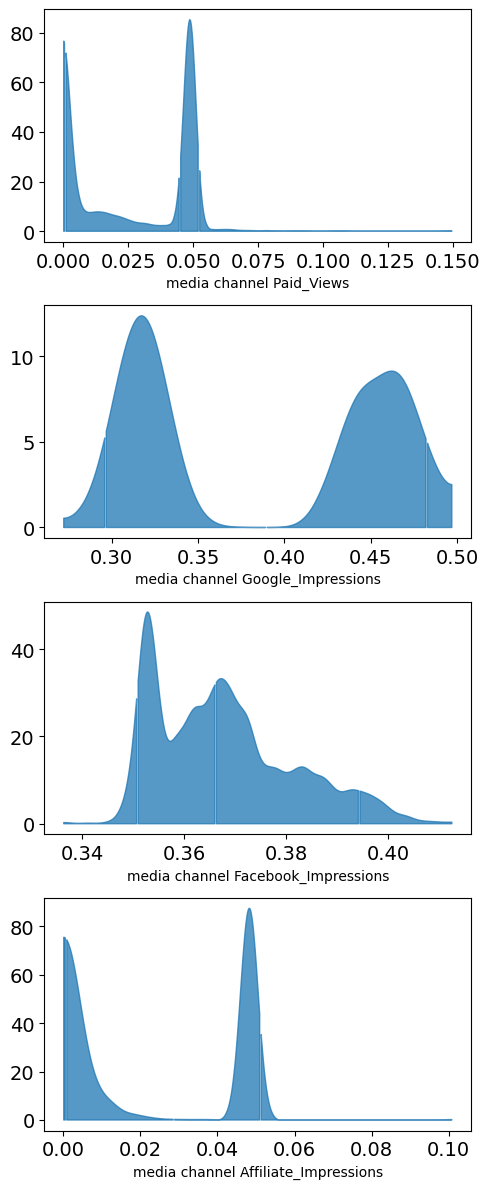

In [58]:
plot.plot_media_channel_posteriors(media_mix_model=mmm_adstock, channel_names=media_cols)

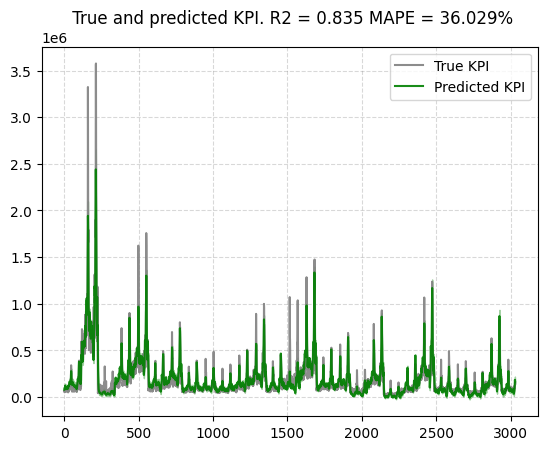

In [59]:
plot.plot_model_fit(mmm_adstock, target_scaler=target_scaler)